In [1]:
import pandas as pd
import re
import string
# from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
from nltk.probability import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import sparse 
import numpy as np

In [2]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [3]:
data_df2 = pd.read_csv("./preprocessed_data/reddit_response_preprocssed_Lem_stopwords_removal1.csv")

In [4]:
data_df2.head()

,Unnamed: 0,op_id,op_gender,post_id,responder_id,response_text,subreddit,responder_gender,responder_gender_visible,response_text_cleaned,response_text_cleaned1
0,0,Kastoli,M,0,Thunda_Storm,or low level. I mean hes wearing black armour ...,2007scape,NaN,unknown_gender,low level. mean he wearing black armour sooo...,"['low', 'level.', 'mean', 'he', 'wearing', 'bl..."
1,1,Kastoli,M,1,Thunda_Storm,So... Low level,2007scape,NaN,unknown_gender,so... low level,"['so...', 'low', 'level']"
2,2,DCBizzle,M,2,minixmatt,"<link> TONK, TONK",2007scape,NaN,unknown_gender,"<link> tonk, tonk","['<link>', 'tonk,', 'tonk']"
3,3,ordona,M,3,Namiweso,Thanks I forgot about that place! :),2007scape,NaN,unknown_gender,thanks forgot place! :),"['thanks', 'forgot', 'place!', ':)']"
4,4,SlayerMaster,M,4,Quantization,Or hes just trolling.,2007scape,NaN,unknown_gender,he trolling.,"['he', 'trolling.']"


In [13]:
data_df2 = data_df2[~ data_df2['response_text_cleaned'].isna()]
data_df2 = data_df2[~ data_df2['responder_gender'].isna()]

In [14]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_df2['response_text_cleaned'])
features = vectorizer.get_feature_names_out()
y = data_df2['op_gender']

In [15]:
X.shape

(133104, 60669)

In [16]:
print(features[:30])

['__' '___' '____' '_____' '______' '_______' '________' '_________'
 '__________' '_____________' '______________________________'
 '__________________________________' '___卐卐卐卐' '_abrdiged_' '_absolutely'
 '_accomplish_' '_actually_' '_all_' '_allow_' '_and' '_and_' '_another_'
 '_anything' '_appalled_' '_are_' '_at' '_bad_' '_balance_' '_be_'
 '_because_']


In [17]:
X.shape, len(y), len(features)

((133104, 60669), 133104, 60669)

In [18]:
type(X)

scipy.sparse._csr.csr_matrix

In [19]:
data_df2['responder_gender']

18         M
851        M
972        M
1012       M
1013       W
          ..
1453273    M
1453274    M
1453275    M
1453277    M
1453285    M
Name: responder_gender, Length: 133104, dtype: object

In [20]:
data_df2['responder_gender1'] = np.where(data_df2['responder_gender']=='W',0,1)
data_df2['responder_gender1']

18         1
851        1
972        1
1012       1
1013       0
          ..
1453273    1
1453274    1
1453275    1
1453277    1
1453285    1
Name: responder_gender1, Length: 133104, dtype: int32

In [21]:

X_new = sparse.hstack((X,np.array(data_df2['responder_gender1'])[:,None]))

In [22]:
X.shape, X_new.shape

((133104, 60669), (133104, 60670))

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [24]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.predict(X_train[:2, :]))
print(clf.predict_proba(X_train[:2, :]))
# >>> clf.score(X, y)

['M' 'M']
[[0.94431265 0.05568735]
 [0.75609132 0.24390868]]


In [25]:
y_train[:2]

138542    M
110773    M
Name: op_gender, dtype: object

In [26]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.776438 using {'C': 0.01, 'penalty': 'l2'}
0.717624 (0.003342) with: {'C': 100, 'penalty': 'l2'}
0.728501 (0.003935) with: {'C': 10, 'penalty': 'l2'}
0.755436 (0.001642) with: {'C': 1.0, 'penalty': 'l2'}
0.772559 (0.000611) with: {'C': 0.1, 'penalty': 'l2'}
0.776438 (0.000607) with: {'C': 0.01, 'penalty': 'l2'}


In [27]:
test_pred = grid_result.predict(X_test)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, test_pred)
print("test accuracy : ", test_acc)

test accuracy :  0.7770290267501423


In [28]:
all_pred = grid_result.predict(X_new)
from sklearn.metrics import accuracy_score
all_acc = accuracy_score(y, all_pred)
print("overall accuracy : ", all_acc)

overall accuracy :  0.7787970308931362


In [29]:
grid_result.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [30]:
features

array(['__', '___', '____', ..., 'ﬁve', 'ﾟдﾟ', 'ﾟヮﾟ'], dtype=object)

In [31]:
features1 = list(features) + ['responder gender']
features1

['__',
 '___',
 '____',
 '_____',
 '______',
 '_______',
 '________',
 '_________',
 '__________',
 '_____________',
 '______________________________',
 '__________________________________',
 '___卐卐卐卐',
 '_abrdiged_',
 '_absolutely',
 '_accomplish_',
 '_actually_',
 '_all_',
 '_allow_',
 '_and',
 '_and_',
 '_another_',
 '_anything',
 '_appalled_',
 '_are_',
 '_at',
 '_bad_',
 '_balance_',
 '_be_',
 '_because_',
 '_blah',
 '_breaking',
 '_can_',
 '_care_',
 '_chandra',
 '_cock_',
 '_completely_',
 '_congress_',
 '_context_',
 '_daaaaaamn_',
 '_do_',
 '_does_',
 '_en',
 '_ever_',
 '_every_',
 '_everything',
 '_everywhere_',
 '_feel_',
 '_fitting_',
 '_fr',
 '_full',
 '_get',
 '_hard_',
 '_hate_',
 '_her_',
 '_hope_',
 '_horribly_',
 '_how_',
 '_human_',
 '_i',
 '_i_',
 '_in',
 '_interest_',
 '_invinoveritas',
 '_invinoveritass',
 '_is',
 '_is_',
 '_ivv',
 '_ivy',
 '_jeebus_',
 '_junc',
 '_just',
 '_just_',
 '_know_',
 '_knuckles_',
 '_law_',
 '_look',
 '_looks_',
 '_loud',
 '_maybe_',
 '

In [32]:
# get importance
importance = grid_result.best_estimator_.coef_[0]
feature_importance = pd.DataFrame({"importance":importance, "features":features1})
feature_importance

,importance,features
0,-0.002697,__
1,0.016886,___
2,0.020558,____
3,0.000000,_____
4,-0.005276,______
...,...,...
60665,-0.002031,ﬁndings
60666,-0.001015,ﬁve
60667,-0.002280,ﾟдﾟ
60668,0.003110,ﾟヮﾟ


In [33]:
feature_importance.sort_values(['importance'],  key=abs, inplace=True)
feature_importance


,importance,features
44396,0.000000,reschedules
51287,0.000000,strudel
39743,0.000000,pickaxe
9910,0.000000,cointelpro
30428,0.000000,lexapro
...,...,...
6697,-0.236551,bro
15868,-0.247081,dude
8104,0.247350,cat
40144,-0.257376,player


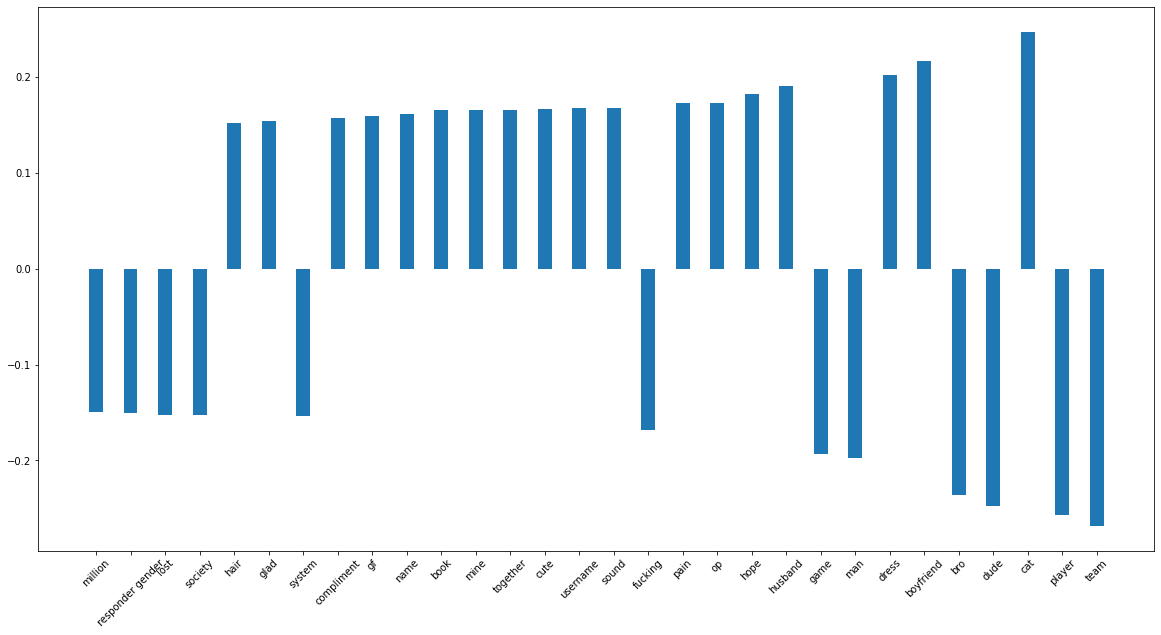

In [34]:
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['features'][-30:], feature_importance['importance'][-30:], width = 0.4)
plt.xticks(rotation=45)
plt.show()

In [35]:
# visualize most freuquent words

In [36]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_df2['response_text_cleaned'])
features = vectorizer.get_feature_names_out()
y = data_df2['op_gender']

In [37]:
data_df2['responder_gender1'] = np.where(data_df2['responder_gender']=='W',0,1)
data_df2['responder_gender1']

18         1
851        1
972        1
1012       1
1013       0
          ..
1453273    1
1453274    1
1453275    1
1453277    1
1453285    1
Name: responder_gender1, Length: 133104, dtype: int32

In [38]:

X_new = sparse.hstack((X,np.array(data_df2['responder_gender1'])[:,None]))

In [39]:
X.shape, X_new.shape

((133104, 60669), (133104, 60670))

In [40]:
feature1 = list(features) + ['responder gender']

In [41]:
X.shape, len(y), len(features1)

((133104, 60669), 133104, 60670)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [43]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.predict(X_train[:2, :]))
print(clf.predict_proba(X_train[:2, :]))
# >>> clf.score(X, y)

['M' 'M']
[[0.91996594 0.08003406]
 [0.82940046 0.17059954]]


In [44]:
y_train[:2]

138542    M
110773    M
Name: op_gender, dtype: object

In [45]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.777257 using {'C': 0.1, 'penalty': 'l2'}
0.732045 (0.002169) with: {'C': 100, 'penalty': 'l2'}
0.751130 (0.000740) with: {'C': 10, 'penalty': 'l2'}
0.776169 (0.000606) with: {'C': 1.0, 'penalty': 'l2'}
0.777257 (0.000024) with: {'C': 0.1, 'penalty': 'l2'}
0.777246 (0.000005) with: {'C': 0.01, 'penalty': 'l2'}


In [46]:
test_pred = grid_result.predict(X_test)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, test_pred)
print("test accuracy : ", test_acc)

test accuracy :  0.7780079681274901


In [47]:
all_pred = grid_result.predict(X_new)
from sklearn.metrics import accuracy_score
all_acc = accuracy_score(y, all_pred)
print("overall accuracy : ", all_acc)

overall accuracy :  0.7774972953479986


In [48]:
grid_result.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [49]:
# get importance
importance = grid_result.best_estimator_.coef_[0]
feature_importance = pd.DataFrame({"importance":importance, "features":features1})
feature_importance

,importance,features
0,-0.013003,__
1,0.035484,___
2,0.062626,____
3,0.000000,_____
4,-0.011090,______
...,...,...
60665,-0.004472,ﬁndings
60666,-0.002236,ﬁve
60667,-0.010036,ﾟдﾟ
60668,0.030306,ﾟヮﾟ


In [50]:
feature_importance.sort_values(['importance'],  key=abs, inplace=True)
feature_importance


,importance,features
23821,0.000000,hatefilled
33167,0.000000,meshy
11709,0.000000,craved
11710,0.000000,craven
33163,0.000000,meself
...,...,...
23346,0.876920,hair
15868,-0.879479,dude
52884,-0.893729,team
8104,0.900172,cat


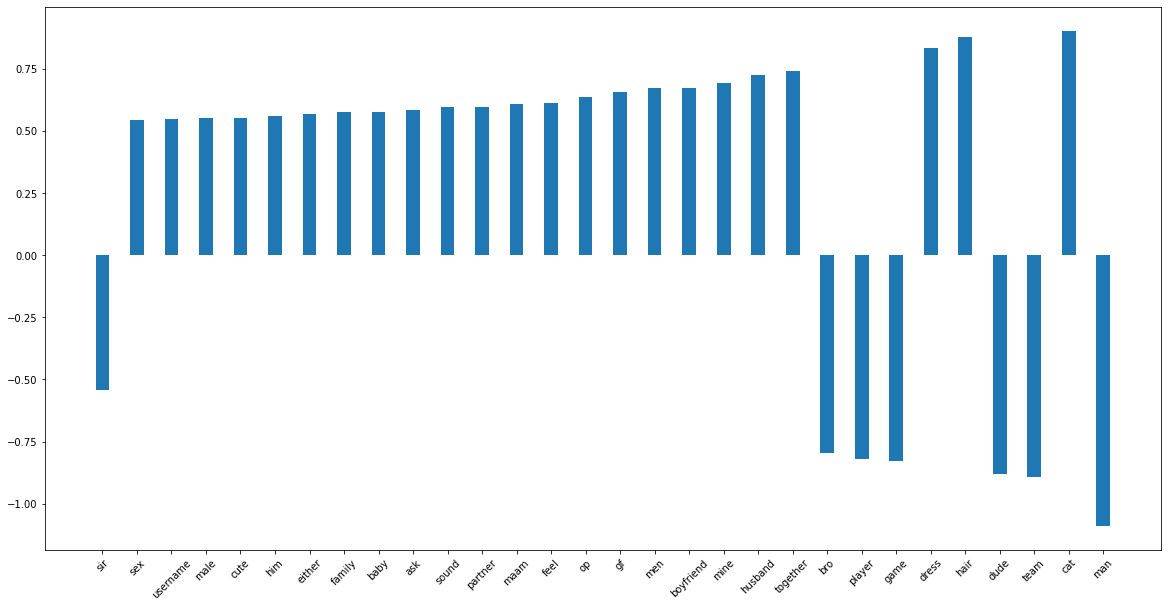

In [51]:
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['features'][-30:], feature_importance['importance'][-30:], width = 0.4)
plt.xticks(rotation=45)
plt.show()

In [52]:
data_df1 = pd.read_csv("./preprocessed_data/reddit_posts_preprocssed_lem_stopwords_removal.csv")

In [53]:
data_df1

,Unnamed: 0,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,post_text_cleaned,post_text_cleaned1
0,0,Kastoli,M,0,slayer task perhaps?,2007scape,False,slayer task perhaps?,"['slayer', 'task', 'perhaps?']"
1,1,Kastoli,M,1,"Black DHide legs, possibly an initiate pure?",2007scape,False,"black dhide legs, possibly initiate pure?","['black', 'dhide', 'legs,', 'possibly', 'initi..."
2,2,DCBizzle,M,2,Whats a tonk? lol,2007scape,False,whats tonk? lol,"['whats', 'tonk?', 'lol']"
3,3,ordona,M,3,Do the Stronghold of Security for a free 10k t...,2007scape,False,stronghold security free start.,"['stronghold', 'security', 'free', 'start.']"
4,4,SlayerMaster,M,4,I cant tell if this guy just doesnt speak Engl...,2007scape,False,cant tell guy doesnt speak english total retar...,"['cant', 'tell', 'guy', 'doesnt', 'speak', 'en..."
...,...,...,...,...,...,...,...,...,...
1453507,1453507,ArconV,M,1453507,I got the game on the summer sale and I have t...,xboxone,False,got game summer sale say im really enjoying it...,"['got', 'game', 'summer', 'sale', 'say', 'im',..."
1453508,1453508,bongo1138,M,1453508,"Id argue that Origin Access is even better, pe...",xboxone,False,"id argue origin access even better, personally.","['id', 'argue', 'origin', 'access', 'even', 'b..."
1453509,1453509,bongo1138,M,1453509,Better selection of non-EA games. Only thing i...,xboxone,False,better selection non-ea games. thing missing v...,"['better', 'selection', 'non-ea', 'games.', 't..."
1453510,1453510,BrandoPB,M,1453510,"I dont know much about the game, but Ive heard...",xboxone,False,"dont know much game, ive heard relaxing. nothi...","['dont', 'know', 'much', 'game,', 'ive', 'hear..."


In [54]:
data_df2

,Unnamed: 0,op_id,op_gender,post_id,responder_id,response_text,subreddit,responder_gender,responder_gender_visible,response_text_cleaned,response_text_cleaned1,responder_gender1
18,18,Tazzak9028,M,18,phySi0,"Dont know why youre being downvoted, this work...",2007scape,M,False,"dont know youre downvoted, work well. annoying...","['dont', 'know', 'youre', 'downvoted,', 'work'...",1
851,851,McFondlebutt,M,851,TheGreatRoh,Their only use would be not unequipping your s...,2007scape,M,False,use would unequipping shield pvp spec.,"['use', 'would', 'unequipping', 'shield', 'pvp...",1
972,972,HumerousMoniker,M,972,uberguby,Isnt that what it says...?,AdviceAnimals,M,False,isnt says...?,"['isnt', 'says...?']",1
1012,1012,sparkymonroe,W,1012,uberguby,I never liked the term gamer. Wtf does that me...,AdviceAnimals,M,False,never liked term gamer. wtf mean? ive never he...,"['never', 'liked', 'term', 'gamer.', 'wtf', 'm...",1
1013,1013,uberguby,M,1013,sparkymonroe,Ill admit Im mostly annoyed because I JUST had...,AdviceAnimals,W,False,ill admit im mostly annoyed discussion another...,"['ill', 'admit', 'im', 'mostly', 'annoyed', 'd...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1453273,1453273,CommanderReg,M,1453273,baldrad,the one where I had to rebuy the game to keep ...,xboxone,M,False,one rebuy game keep able purchase future dlc...,"['one', 'rebuy', 'game', 'keep', 'able', 'purc...",1
1453274,1453274,baldrad,M,1453274,CommanderReg,Sounds weird. Re buy for a different system? B...,xboxone,M,False,sound weird. buy different system? got free sw...,"['sound', 'weird.', 'buy', 'different', 'syste...",1
1453275,1453275,CommanderReg,M,1453275,baldrad,"No, never was offered free switch up.",xboxone,M,False,"no, never offered free switch up.","['no,', 'never', 'offered', 'free', 'switch', ...",1
1453277,1453277,baldrad,M,1453277,CommanderReg,Still though thats re-buying for a different s...,xboxone,M,False,still though thats re-buying different system....,"['still', 'though', 'thats', 're-buying', 'dif...",1


In [55]:
data_df3 = data_df2.merge(data_df1, on=['op_id', 'post_id'])

In [56]:
data_df3

,Unnamed: 0_x,op_id,op_gender_x,post_id,responder_id,response_text,subreddit_x,responder_gender,responder_gender_visible,response_text_cleaned,response_text_cleaned1,responder_gender1,Unnamed: 0_y,op_gender_y,post_text,subreddit_y,op_gender_visible,post_text_cleaned,post_text_cleaned1
0,18,Tazzak9028,M,18,phySi0,"Dont know why youre being downvoted, this work...",2007scape,M,False,"dont know youre downvoted, work well. annoying...","['dont', 'know', 'youre', 'downvoted,', 'work'...",1,18,M,"If youre using 07, just click on the black par...",2007scape,False,"youre using , click black part webpage. source...","['youre', 'using', ',', 'click', 'black', 'par..."
1,851,McFondlebutt,M,851,TheGreatRoh,Their only use would be not unequipping your s...,2007scape,M,False,use would unequipping shield pvp spec.,"['use', 'would', 'unequipping', 'shield', 'pvp...",1,851,M,Four months later: Dragon hastas are dead con...,2007scape,False,four month later: dragon hastas dead content n...,"['four', 'month', 'later:', 'dragon', 'hastas'..."
2,972,HumerousMoniker,M,972,uberguby,Isnt that what it says...?,AdviceAnimals,M,False,isnt says...?,"['isnt', 'says...?']",1,972,M,I read this as >your email and Ill... get in...,AdviceAnimals,False,read >your email ill... get,"['read', '>your', 'email', 'ill...', 'get']"
3,1012,sparkymonroe,W,1012,uberguby,I never liked the term gamer. Wtf does that me...,AdviceAnimals,M,False,never liked term gamer. wtf mean? ive never he...,"['never', 'liked', 'term', 'gamer.', 'wtf', 'm...",1,1012,W,I disagree. I consider a gamer to be someone w...,AdviceAnimals,False,disagree. consider gamer someone count gaming ...,"['disagree.', 'consider', 'gamer', 'someone', ..."
4,1013,uberguby,M,1013,sparkymonroe,Ill admit Im mostly annoyed because I JUST had...,AdviceAnimals,W,False,ill admit im mostly annoyed discussion another...,"['ill', 'admit', 'im', 'mostly', 'annoyed', 'd...",0,1013,M,I never liked the term gamer. Wtf does that me...,AdviceAnimals,False,never liked term gamer. wtf mean? ive never he...,"['never', 'liked', 'term', 'gamer.', 'wtf', 'm..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133099,1453273,CommanderReg,M,1453273,baldrad,the one where I had to rebuy the game to keep ...,xboxone,M,False,one rebuy game keep able purchase future dlc...,"['one', 'rebuy', 'game', 'keep', 'able', 'purc...",1,1453273,M,Which upgrade patch are you referring to?,xboxone,False,upgrade patch referring to?,"['upgrade', 'patch', 'referring', 'to?']"
133100,1453274,baldrad,M,1453274,CommanderReg,Sounds weird. Re buy for a different system? B...,xboxone,M,False,sound weird. buy different system? got free sw...,"['sound', 'weird.', 'buy', 'different', 'syste...",1,1453274,M,the one where I had to rebuy the game to keep ...,xboxone,False,one rebuy game keep able purchase future dlc...,"['one', 'rebuy', 'game', 'keep', 'able', 'purc..."
133101,1453275,CommanderReg,M,1453275,baldrad,"No, never was offered free switch up.",xboxone,M,False,"no, never offered free switch up.","['no,', 'never', 'offered', 'free', 'switch', ...",1,1453275,M,Sounds weird. Re buy for a different system? B...,xboxone,False,sound weird. buy different system? got free sw...,"['sound', 'weird.', 'buy', 'different', 'syste..."
133102,1453277,baldrad,M,1453277,CommanderReg,Still though thats re-buying for a different s...,xboxone,M,False,still though thats re-buying different system....,"['still', 'though', 'thats', 're-buying', 'dif...",1,1453277,M,"No, never was offered free switch up.",xboxone,False,"no, never offered free switch up.","['no,', 'never', 'offered', 'free', 'switch', ..."


In [57]:
data_df3['total_text'] = data_df3['response_text_cleaned'] + data_df3['post_text_cleaned']
data_df3['total_text']

0         dont know youre downvoted, work well. annoying...
1         use would unequipping shield pvp spec.four mon...
2                  isnt says...?read >your email ill... get
3         never liked term gamer. wtf mean? ive never he...
4         ill admit im mostly annoyed discussion another...
                                ...                        
133099    one rebuy game keep able purchase future dlc.....
133100    sound weird. buy different system? got free sw...
133101    no, never offered free switch up.sound weird. ...
133102    still though thats re-buying different system....
133103    how?  ? isnt new system one rebuy keep getting...
Name: total_text, Length: 133104, dtype: object

In [58]:
data_df3= data_df3[~data_df3['total_text'].isna()]

In [59]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_df3['total_text'])
features = vectorizer.get_feature_names_out()
y = data_df3['op_gender_y']

In [60]:
X.shape

(133043, 92686)

In [61]:
print(features[:30])

['__' '___' '____' '_____' '______' '_______' '________' '_________'
 '__________' '___________' '_____________' '_________________________'
 '______________________________' '__________________________________'
 '___________________________________'
 '________________________________________'
 '__________________________________________________' '____oh'
 '___卐卐卐卐nah' '__other__' '_abrdiged_' '_absolutely' '_accomplish_'
 '_actually_' '_after_' '_all_' '_allow_' '_already_' '_and' '_and_']


In [62]:
X.shape, len(y), len(features)

((133043, 92686), 133043, 92686)

In [63]:
type(X)

scipy.sparse._csr.csr_matrix

In [64]:
data_df2['responder_gender']

18         M
851        M
972        M
1012       M
1013       W
          ..
1453273    M
1453274    M
1453275    M
1453277    M
1453285    M
Name: responder_gender, Length: 133104, dtype: object

In [65]:
data_df2['responder_gender1'] = np.where(data_df2['responder_gender']=='W',0,1)
data_df2['responder_gender1']

18         1
851        1
972        1
1012       1
1013       0
          ..
1453273    1
1453274    1
1453275    1
1453277    1
1453285    1
Name: responder_gender1, Length: 133104, dtype: int32

In [66]:

X_new = sparse.hstack((X,np.array(data_df3['responder_gender1'])[:,None]))

In [67]:
X.shape, X_new.shape

((133043, 92686), (133043, 92687))

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [69]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.predict(X_train[:2, :]))
print(clf.predict_proba(X_train[:2, :]))
# >>> clf.score(X, y)

['W' 'M']
[[0.30130824 0.69869176]
 [0.76711803 0.23288197]]


In [70]:
y_train[:2]

125612    W
32602     M
Name: op_gender_y, dtype: object

In [71]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.776717 using {'C': 0.01, 'penalty': 'l2'}
0.725044 (0.004622) with: {'C': 100, 'penalty': 'l2'}
0.727310 (0.001527) with: {'C': 10, 'penalty': 'l2'}
0.750510 (0.001393) with: {'C': 1.0, 'penalty': 'l2'}
0.772297 (0.001743) with: {'C': 0.1, 'penalty': 'l2'}
0.776717 (0.000516) with: {'C': 0.01, 'penalty': 'l2'}


In [72]:
test_pred = grid_result.predict(X_test)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, test_pred)
print("test accuracy : ", test_acc)

test accuracy :  0.7789317845347911


In [73]:
all_pred = grid_result.predict(X_new)
from sklearn.metrics import accuracy_score
all_acc = accuracy_score(y, all_pred)
print("overall accuracy : ", all_acc)

overall accuracy :  0.783017520651218


In [74]:
grid_result.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [75]:
features

array(['__', '___', '____', ..., 'ﾟдﾟ', 'ﾟヮﾟ', 'ﾟﾟ'], dtype=object)

In [76]:
features1 = list(features) + ['responder gender']
features1

['__',
 '___',
 '____',
 '_____',
 '______',
 '_______',
 '________',
 '_________',
 '__________',
 '___________',
 '_____________',
 '_________________________',
 '______________________________',
 '__________________________________',
 '___________________________________',
 '________________________________________',
 '__________________________________________________',
 '____oh',
 '___卐卐卐卐nah',
 '__other__',
 '_abrdiged_',
 '_absolutely',
 '_accomplish_',
 '_actually_',
 '_after_',
 '_all_',
 '_allow_',
 '_already_',
 '_and',
 '_and_',
 '_another_',
 '_anything',
 '_anything_',
 '_appalled_',
 '_are_',
 '_arent_',
 '_as',
 '_at',
 '_awesome_',
 '_awkward',
 '_bad_',
 '_balance_',
 '_be_',
 '_because_',
 '_being',
 '_blah',
 '_breaking',
 '_can_',
 '_care_',
 '_chandra',
 '_cock_',
 '_completely_',
 '_congress_',
 '_context_',
 '_contrast_',
 '_daaaaaamn_',
 '_deserved_',
 '_destroyerthekitten',
 '_didnt',
 '_do_',
 '_does_',
 '_done_',
 '_dont',
 '_dont_',
 '_during_',
 '_en',
 '_

In [77]:
# get importance
importance = grid_result.best_estimator_.coef_[0]
feature_importance = pd.DataFrame({"importance":importance, "features":features1})
feature_importance

,importance,features
0,-0.004163,__
1,-0.013337,___
2,0.055836,____
3,-0.010767,_____
4,-0.008787,______
...,...,...
92682,-0.001992,ﾟjob
92683,-0.001352,ﾟдﾟ
92684,0.000460,ﾟヮﾟ
92685,0.000000,ﾟﾟ


In [78]:
feature_importance.sort_values(['importance'],  key=abs, inplace=True)
feature_importance


,importance,features
46047,0.000000,liftedright
27882,0.000000,fasterracing
11231,0.000000,cabaye
27881,0.000000,fastereven
60115,0.000000,pewpewpew
...,...,...
61110,-0.246605,player
80845,0.271525,thank
84636,0.333817,ugh
38450,0.503888,husband


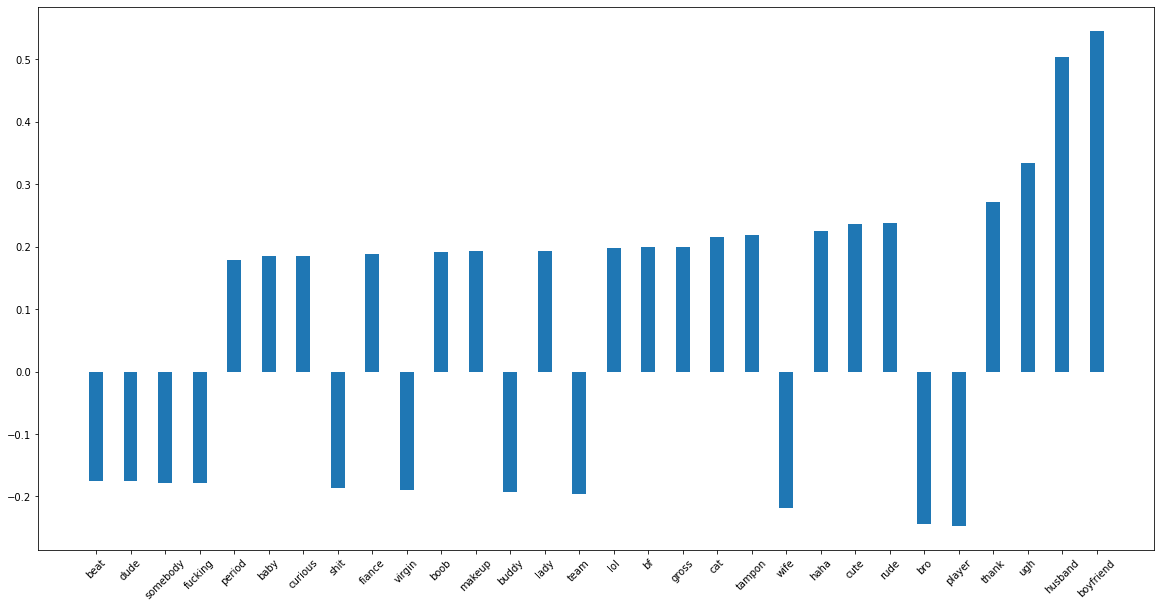

In [79]:
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['features'][-30:], feature_importance['importance'][-30:], width = 0.4)
plt.xticks(rotation=45)
plt.show()